# Applying Deep Learning to solve a Client Success problem - Duty Manager call prediction

GOAL: predict tickets that will generate a Duty Manager (DM) call

- ~1.5% of Db2 tickets generate DM calls; each call generates additional work/impedence for the customer, the analyst, and the Duty Manager
- if we could predict which tickets will generate DM calls, and take proactive actions on those tickets (e.g. proactively call customer), all stakeholders benefit
- train a simple deep learning model on Db2 ticket data Feb 1 - May 20, 2018


FEATURES:

- categorical: CASE_OWNER_ALIAS, SUPPORT_MISSION, CREATED_BY, ACCOUNT_NAME, LEGACY_PROBLEM_NUMBER, SEVERITY_LEVEL_NUMBER_FORMULA, OPERATING_SYSTEM, PRODUCT_NAME, ACCOUNT_PRIORITY, PRODUCT_VERSION, BLUE_DIAMOND_ACCOUNT
- continuous: OWNERSHIP_CHANGES
- text: SUBJECT

LABEL / TARGET:

- will the ticket generate a DM call? 0 if no; 1 if yes



# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

In [79]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode
savepath = '/home/paperspace/models/'
readpath = '/home/paperspace/data/dmprediction/'

testproportion = 0.01 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = True # switch to determine whether to save model
picklemodel = True # switch for code to allow pickling of Keras model
hctextmax = 7000
maxwords = 6000

targetthresh = 6.0
emptythresh = 6000
# to address imbalance in training data between zero (above targetthresh) and detractor (below targetthresh) specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 72.8

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5


In [80]:
import urllib.request
request = urllib.request.urlopen('http://www.google.com/')
#response = urllib.urlopen(request)
#if response.getcode() == 200:
#   print("200")

In [81]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# from sklearn.preprocessing import CategoricalEncoder

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
import seaborn as sns

#model libraries


from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model


# Ingest data <a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [82]:
if pSpace == True:    
    dm_cases = pd.read_csv('/home/paperspace/data/dmprediction/dmcasesmay202018.csv',encoding = "ISO-8859-1")
    merged_data = pd.read_csv('/home/paperspace/data/dmprediction/alldmeracasesmay20updatedjune2.csv',encoding = "ISO-8859-1")
    superset_data = pd.read_csv('/home/paperspace/data/dmprediction/alldmeracasesjune2b2018.csv',encoding = "ISO-8859-1")
    merged_data.columns = map(str.upper,merged_data.columns)
    dm_cases.columns = map(str.upper,dm_cases.columns)
    superset_data.columns = map(str.upper,superset_data.columns)



In [83]:
dm_cases.shape

(104, 14)

In [84]:
merged_data.shape

(7514, 15)

In [85]:
# columns = ['Col1', 'Col2', ...]
# df.drop(columns, inplace=True, axis=1)
dm_cases["target"] = 1



In [86]:
dmcollist = list(dm_cases)
dmexlist = ['CASE_NUMBER','target']
# collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty))
dmcollist = list(set(dmcollist) - set(dmexlist))
dmcollist

['WATSON_SKILL_SUGGESTION_(DEPRECATED)',
 'CASE_OWNER_ALIAS',
 'SUBJECT',
 'ACCOUNT_PRIORITY',
 'BLUE_DIAMOND_ACCOUNT',
 'STATUS',
 'LEGACY_PROBLEM_NUMBER',
 'ACCOUNT_NAME_TEXT',
 'SEVERITY_LEVEL',
 'DATE_OPENED',
 'CONTACT_NAME',
 'COUNTRY',
 'OWNER_LAST_NAME']

In [87]:
# df.drop(columns, inplace=True, axis=1)
dm_cases.drop(dmcollist, inplace=True, axis=1)
print("dm_cases cols post pruning",list(dm_cases))

dm_cases cols post pruning ['CASE_NUMBER', 'target']


In [88]:
dm_cases.target.value_counts()

1    104
Name: target, dtype: int64

In [89]:
dm_cases.shape

(104, 2)

In [90]:
# merge the dm_cases dataframe with the overall cases dataframe
merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')

In [91]:
merged_data.shape

(7514, 16)

In [92]:
merged_data.target.value_counts()

1.0    84
Name: target, dtype: int64

In [93]:
# df.loc[df['column_name'] == some_value]
messed = merged_data.loc[merged_data['SUPPORT_MISSION'].isna()]
messed.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target


In [94]:
# df['column']=df['column'].fillna(value)
merged_data['target']=merged_data['target'].fillna(0.0)
merged_data.target.value_counts()

0.0    7430
1.0      84
Name: target, dtype: int64

In [95]:
merged_data.shape

(7514, 16)

In [96]:
print("md shape",merged_data.shape)

md shape (7514, 16)


In [97]:
print("superset shape",superset_data.shape)

superset shape (8561, 15)


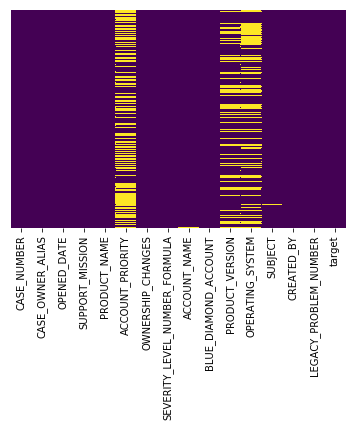

In [98]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [99]:
nearempty = []
for c in merged_data.columns:
    if np.sum(merged_data[c].isnull()) >= emptythresh :
        print(c)
        nearempty.append(c)
print(nearempty)

[]


# Clean up data

Go through steps to prepare data.

# Define test / training sets; fill in missing values; encode categorical values; process text field

In [100]:
# clean up LEGACY_PROBLEM_NUMBER
merged_data['LEGACY_PROBLEM_NUMBER'] = np.where(merged_data['LEGACY_PROBLEM_NUMBER'] == 'Not Applicable','Not Applicable','PMR')
superset_data['LEGACY_PROBLEM_NUMBER'] = np.where(superset_data['LEGACY_PROBLEM_NUMBER'] == 'Not Applicable','Not Applicable','PMR')

In [101]:
# get training and test data set

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)



Through train test split. Test proportion:
0.01


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [102]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['CASE_NUMBER', 'CASE_OWNER_ALIAS', 'OPENED_DATE', 'SUPPORT_MISSION', 'PRODUCT_NAME', 'ACCOUNT_PRIORITY', 'OWNERSHIP_CHANGES', 'SEVERITY_LEVEL_NUMBER_FORMULA', 'ACCOUNT_NAME', 'BLUE_DIAMOND_ACCOUNT', 'PRODUCT_VERSION', 'OPERATING_SYSTEM', 'SUBJECT', 'CREATED_BY', 'LEGACY_PROBLEM_NUMBER', 'target']


In [103]:
# define the required column lists

textcols = ['SUBJECT'] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
continuouscols = ['OWNERSHIP_CHANGES'] # columns to deal with as continuous values - no embeddings
excludefromcolist = ['CASE_NUMBER','target','OPENED_DATE'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("nearempty",len(nearempty))
print(nearempty)
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 16
nearempty 0
[]
excludefromcolist 3
['CASE_NUMBER', 'target', 'OPENED_DATE']
textcols 1
['SUBJECT']
continuouscols 1
['OWNERSHIP_CHANGES']
collist 11
['CASE_OWNER_ALIAS', 'SUPPORT_MISSION', 'SEVERITY_LEVEL_NUMBER_FORMULA', 'ACCOUNT_PRIORITY', 'BLUE_DIAMOND_ACCOUNT', 'OPERATING_SYSTEM', 'LEGACY_PROBLEM_NUMBER', 'PRODUCT_VERSION', 'CREATED_BY', 'ACCOUNT_NAME', 'PRODUCT_NAME']


In [104]:
# ensure continuous columns have numeric type
for col in continuouscols:
    print("col is",col)
    merged_data[col] = merged_data[col].astype(float)
    print("got through one")
    superset_data[col] = superset_data[col].astype(float)

col is OWNERSHIP_CHANGES
got through one


In [105]:
superset_data.dtypes

CASE_NUMBER                       object
CASE_OWNER_ALIAS                  object
OPENED_DATE                       object
SUPPORT_MISSION                   object
PRODUCT_NAME                      object
ACCOUNT_PRIORITY                  object
OWNERSHIP_CHANGES                float64
SEVERITY_LEVEL_NUMBER_FORMULA     object
ACCOUNT_NAME                      object
BLUE_DIAMOND_ACCOUNT              object
PRODUCT_VERSION                   object
OPERATING_SYSTEM                  object
SUBJECT                           object
CREATED_BY                        object
LEGACY_PROBLEM_NUMBER             object
dtype: object

In [106]:
merged_data.dtypes

CASE_NUMBER                       object
CASE_OWNER_ALIAS                  object
OPENED_DATE                       object
SUPPORT_MISSION                   object
PRODUCT_NAME                      object
ACCOUNT_PRIORITY                  object
OWNERSHIP_CHANGES                float64
SEVERITY_LEVEL_NUMBER_FORMULA     object
ACCOUNT_NAME                      object
BLUE_DIAMOND_ACCOUNT              object
PRODUCT_VERSION                   object
OPERATING_SYSTEM                  object
SUBJECT                           object
CREATED_BY                        object
LEGACY_PROBLEM_NUMBER             object
target                           float64
dtype: object

In [107]:
superset_data['LEGACY_PROBLEM_NUMBER'].head(10)

0    Not Applicable
1               PMR
2    Not Applicable
3    Not Applicable
4               PMR
5    Not Applicable
6    Not Applicable
7    Not Applicable
8               PMR
9               PMR
Name: LEGACY_PROBLEM_NUMBER, dtype: object

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [108]:
# fill missing values
print("before mv")
def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)


train = fill_missing(train)
test = fill_missing(test)
# also remove missing data from superset dataset used for encodings
superset_data = fill_missing(superset_data)



before mv


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [109]:
# process categorical data
# replace values with category IDs in the categorical columns
# 


lelist = {}

for col in collist:
    le = LabelEncoder()
    if verboseout:
        print("processing ",col)
    # fit on superset to ensure encoding includes future data but only model on past data
    # np.hstack([superset_data[col]])
    le.fit(np.hstack([superset_data[col]]))
    superset_data[col] = le.transform(superset_data[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    lelist[col] = le
    del le
    
    
train.head(5)
    

processing  CASE_OWNER_ALIAS


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


processing  SUPPORT_MISSION
processing  SEVERITY_LEVEL_NUMBER_FORMULA
processing  ACCOUNT_PRIORITY
processing  BLUE_DIAMOND_ACCOUNT
processing  OPERATING_SYSTEM
processing  LEGACY_PROBLEM_NUMBER
processing  PRODUCT_VERSION
processing  CREATED_BY
processing  ACCOUNT_NAME
processing  PRODUCT_NAME


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
6238,TS000866808,199,05/01/2018,0,6,18,0,1,965,1,7,2,C 5/24 db2 mpp v2 on cloud instance hung. RCA ...,1268,0,0.0
1553,TS000117500,188,2/16/2018,0,6,4,0,1,197,1,5,2,SQL0551N from db2look after restoring db from ...,222,0,0.0
6988,TS000896364,220,05/11/2018,0,6,18,0,2,1123,1,30,0,Proactive PMR,728,0,0.0
3112,TS000143135,208,3/13/2018,0,6,18,0,1,614,1,5,0,GCGTSC@TM: Tracking DB2 deadlock,1819,1,0.0
1357,TS000115037,229,2/14/2018,0,6,10,1,1,1735,1,40,5,DB2 WLB is not working correctly,1819,1,0.0


In [110]:
superset_data.head(5)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER
0,TS000104648,13,02/01/2018,0,6,10,0.0,1,1373,1,5,5,DB2 running out of disk space during data-inte...,109,0
1,TS000104657,119,02/01/2018,0,6,18,1.0,1,1798,1,40,5,C-3/27-(0)-W4F 180205 insert and delete transa...,1819,1
2,TS000104966,244,02/01/2018,0,6,18,1.0,2,1717,1,5,5,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,276,0
3,TS000105031,59,02/01/2018,0,6,18,1.0,1,1717,1,5,5,SAP 47709/2018 - Productive Database db2 down ...,1096,0
4,TS000105069,112,02/01/2018,0,6,2,0.0,1,1123,1,30,5,HADR tuning,1819,1


In [111]:
train['SUBJECT'].head(10)

6238    C 5/24 db2 mpp v2 on cloud instance hung. RCA ...
1553    SQL0551N from db2look after restoring db from ...
6988                                        Proactive PMR
3112                     GCGTSC@TM: Tracking DB2 deadlock
1357                     DB2 WLB is not working correctly
6122                                           DPL PASSED
338     C-6/04-(0)-Poor and slow compression with LOGA...
3903                         GCGTSC@ZY:Db2:instance crash
2557                                           HADR Error
1648    Uso da API "Entity Framework", da IBM, para ac...
Name: SUBJECT, dtype: object

In [112]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=maxwords,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    


processing text col SUBJECT


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [113]:
train['SUBJECT'].head(10)

6238    [40, 8, 464, 1, 2889, 488, 4, 927, 35, 147, 15...
1553            [1152, 27, 440, 24, 546, 22, 27, 688, 59]
6988                                           [393, 135]
3112                               [3, 201, 2890, 1, 429]
1357                         [1, 1582, 14, 13, 107, 1153]
6122                                         [1336, 1154]
338      [40, 197, 97, 57, 841, 16, 72, 689, 12, 2000, 4]
3903                                   [3, 23, 1, 35, 50]
2557                                              [20, 9]
1648    [2891, 1155, 583, 1583, 1038, 1155, 45, 547, 2...
Name: SUBJECT, dtype: object

In [114]:
# define max values for embeddings


max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



maxtrain.max() 5999
maxtest .max() 5771
textmax 7000
max_dict {'CASE_OWNER_ALIAS': 269, 'SUPPORT_MISSION': 1, 'SEVERITY_LEVEL_NUMBER_FORMULA': 4, 'ACCOUNT_PRIORITY': 19, 'BLUE_DIAMOND_ACCOUNT': 2, 'OPERATING_SYSTEM': 6, 'LEGACY_PROBLEM_NUMBER': 2, 'PRODUCT_VERSION': 43, 'CREATED_BY': 2276, 'ACCOUNT_NAME': 2215, 'PRODUCT_NAME': 28, 'SUBJECT': 5999}


# Split training set into train / validate

In [115]:
# define and scale target and get validation sets

dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head(10)
else:
    #trn_labels[:4]
    print(dtrain["target"][:2])
    print(dvalid.target[:2])
    




(5950, 16)
(1488, 16)


In [116]:
# print counts of target values for data sets
print("zero target values: all",(merged_data["target"]==0).sum())
print("one target values: all",(merged_data["target"]==1).sum())
print("zero target values: dtrain",(dtrain["target"]==0).sum())
print("one target values: dtrain",(dtrain["target"]==1).sum())
print("zero target values: dvalid",(dvalid["target"]==0).sum())
print("one target values: dvalid",(dvalid["target"]==1).sum())


zero target values: all 7430
one target values: all 84
zero target values: dtrain 5882
one target values: dtrain 68
zero target values: dvalid 1473
one target values: dvalid 15


In [117]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input
X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)
print("keras variables defined")
print("X_train_list",X_train_list)





cat col is CASE_OWNER_ALIAS
cat col is SUPPORT_MISSION
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
cat col is ACCOUNT_PRIORITY
cat col is BLUE_DIAMOND_ACCOUNT
cat col is OPERATING_SYSTEM
cat col is LEGACY_PROBLEM_NUMBER
cat col is PRODUCT_VERSION
cat col is CREATED_BY
cat col is ACCOUNT_NAME
cat col is PRODUCT_NAME
text col is SUBJECT
cont col is OWNERSHIP_CHANGES
cat col is CASE_OWNER_ALIAS
cat col is SUPPORT_MISSION
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
cat col is ACCOUNT_PRIORITY
cat col is BLUE_DIAMOND_ACCOUNT
cat col is OPERATING_SYSTEM
cat col is LEGACY_PROBLEM_NUMBER
cat col is PRODUCT_VERSION
cat col is CREATED_BY
cat col is ACCOUNT_NAME
cat col is PRODUCT_NAME
text col is SUBJECT
cont col is OWNERSHIP_CHANGES
cat col is CASE_OWNER_ALIAS
cat col is SUPPORT_MISSION
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
cat col is ACCOUNT_PRIORITY
cat col is BLUE_DIAMOND_ACCOUNT
cat col is OPERATING_SYSTEM
cat col is LEGACY_PROBLEM_NUMBER
cat col is PRODUCT_VERSION
cat col is CREATED_BY
cat co

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [118]:
# define model in Keras

def get_model():
    
          
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    
      
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    
    
    # define layers for text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        
    # define layers for continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
              
    # build up layers
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['ACCOUNT_NAME']) ),Dropout(dropout_rate) (Flatten() (embeddings['CASE_OWNER_ALIAS']) )])
    for cols in collist:
        if (cols != 'ACCOUNT_NAME') & (cols != 'CASE_OWNER_ALIAS'):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
       
    
    # define output layer
    output = Dense(1, activation="sigmoid") (main_l)
    # output = Dense(1, activation="linear") (main_l)
    
    # define model        
                                                  
    model = Model(inputlayerlist, output)
    
       
    # define optimizer
    optimizer = SGD(lr=learning_rate)
   
    # compile model
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
         
    
    return model

    
model = get_model()

# output model summary

model.summary()
    

    

about to define embeddings
textmax is 7000
col SUBJECT
text input shape 5999
max in the midst 6005
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_36/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ACCOUNT_NAME (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
CASE_OWNER_ALIAS (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 1, 10)        22150       ACCOUNT_NAME[0][0]               
____________________________________________________________________

In [119]:
BATCH_SIZE = 200
epochs = 10
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)


model = get_model()
modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols ['SUBJECT']
dropout  0.0003
L2 lambda  0.0003
batch size  200
about to define embeddings
textmax is 7000
col SUBJECT
text input shape 5999
max in the midst 6005
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_48/concat:0", shape=(?, ?), dtype=float32)
Train on 5950 samples, validate on 1488 samples
Epoch 1/10
5950/5950 [==============================] - 159s 27ms/step - loss: 1.3689 - acc: 0.4151 - weighted_acc: 0.8978 - val_loss: 0.7035 - val_acc: 0.6452 - val_weighted_acc: 0.6452
Epoch 2/10
5950/5950 [==============================] - 158s 27ms/step - loss: 1.2345 - acc: 0.5052 - weighted_acc: 1.0965 - val_loss: 0.6991 - val_acc: 0.6815 - val_weighted_acc: 0.6815
Epoch 3/10
5950/5950 [==============================] - 156s 26ms/step - loss: 1.1528 - acc: 0.5667 - weighted_acc: 1.1942 - val_loss: 0.6941 - val_acc: 0.7016 - val_weighted_acc: 0.7016
Epoch 4/10
5950/5950 [==============================] - 157s 26ms/step - loss: 1

In [120]:
modifier = "nov5b"
if savemodel == True:
    model_json = model.to_json()
    with open(savepath+'model'+modifier+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(savepath+'dmweights'+modifier+'.h5')
    
    # save tokenizer tok_raw for text and label encoder for categorical cols
    with open(savepath+'tokenizer'+modifier+'.pickle', 'wb') as handle:
        pickle.dump(tok_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(savepath+'le'+modifier+'.pickle', 'wb') as handle2:
        pickle.dump(lelist, handle2, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved model, weights, tokenizer and label encoder to disk")
    with open(savepath+'ne'+modifier+'.pickle', 'wb') as handle3:
        pickle.dump(nearempty, handle3, protocol=pickle.HIGHEST_PROTOCOL)
    
    model.save(savepath+'dmmodel'+modifier+'.h5')
    print("Saved model, weights, tokenizer and label encoder to disk")


Saved model, weights, tokenizer and label encoder to disk
Saved model, weights, tokenizer and label encoder to disk


# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [54]:
from keras.models import load_model
new_model = load_model(savepath+'dmmodel'+modifier+'.h5')

In [55]:
if presaved == True:
    BATCH_SIZE = 200
    epochs = 1
    modelfit2 = new_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

In [56]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ACCOUNT_NAME (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
CASE_OWNER_ALIAS (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 10)        22150       ACCOUNT_NAME[0][0]               
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 10)        2690        CASE_OWNER_ALIAS[0][0]           
__________________________________________________________________________________________________
SUPPORT_MI

# Predictions and renderings

In [121]:
# functions to parse and manipulate dates in the style of the input CSVs
import datetime
from datetime import date
def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [122]:
# predictions on training set

preds = model.predict(X_train, batch_size=BATCH_SIZE)

In [123]:
len(lelist)

11

In [124]:
preds.shape

(5950, 1)

In [125]:
preds[:50]

array([[ 0.47658885],
       [ 0.48568058],
       [ 0.51618594],
       [ 0.54550904],
       [ 0.48846439],
       [ 0.44110146],
       [ 0.35933176],
       [ 0.46696281],
       [ 0.46008301],
       [ 0.52748609],
       [ 0.45919886],
       [ 0.41886404],
       [ 0.39999038],
       [ 0.43974134],
       [ 0.41980836],
       [ 0.47716776],
       [ 0.43132985],
       [ 0.46688703],
       [ 0.51388305],
       [ 0.44410166],
       [ 0.45134065],
       [ 0.41294196],
       [ 0.40390512],
       [ 0.48919168],
       [ 0.4630186 ],
       [ 0.54636103],
       [ 0.47538921],
       [ 0.41760489],
       [ 0.44419828],
       [ 0.35426328],
       [ 0.35809675],
       [ 0.49904078],
       [ 0.4187327 ],
       [ 0.49405068],
       [ 0.4368012 ],
       [ 0.58154649],
       [ 0.40500203],
       [ 0.49542972],
       [ 0.45565513],
       [ 0.4841933 ],
       [ 0.47077447],
       [ 0.49711803],
       [ 0.44285139],
       [ 0.38223869],
       [ 0.38384244],
       [ 0

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


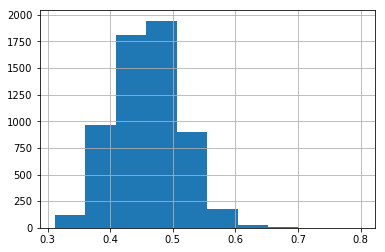

In [126]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

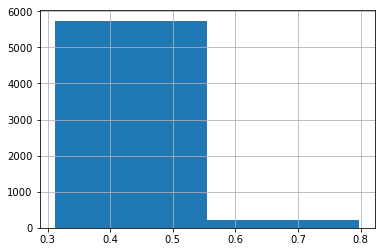

In [127]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [128]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

<class 'numpy.ndarray'>
(5950, 1)
<class 'pandas.core.series.Series'>


In [131]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


810     0
7110    0
3967    1
3800    1
627     0
Name: predround, dtype: int64

In [132]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



1273.0
percentage correct train
0.786050420168


In [133]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


6508    0.488539
3460    0.523025
2945    0.388055
6663    0.397696
4871    0.365404
Name: predict, dtype: float32

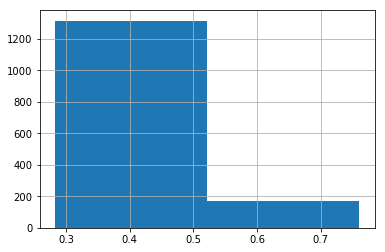

In [134]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [135]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


6508    0.0
3460    1.0
2945    0.0
6663    0.0
4871    0.0
4380    1.0
110     1.0
1582    1.0
6088    1.0
1823    1.0
Name: deltaval, dtype: float64
337.0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [136]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target,predround,predict,deltaval
3460,TS000149858,247,3/19/2018,0,6,2,1,1,1268,1,40,5,"[3, 3386, 1694, 99, 36, 2, 876, 99, 20, 738, 293]",1819,1,0.0,1,0.523025,1.0
4380,TS000162980,103,3/29/2018,0,11,18,0,0,988,1,40,5,"[22, 499, 5, 642, 159, 7, 349]",1578,0,0.0,1,0.519243,1.0
110,TS000130911,112,03/05/2018,0,6,0,0,1,216,1,5,2,"[10, 14, 105, 147]",439,0,0.0,1,0.525033,1.0
1582,TS000117826,188,2/18/2018,0,6,10,1,1,812,1,5,2,"[188, 64, 52, 2, 33, 320, 298, 1363, 4, 1, 60,...",1470,0,0.0,1,0.521524,1.0
6088,TS000841054,212,4/27/2018,0,6,10,0,0,629,1,40,5,"[745, 52, 2, 1774, 2292, 284, 867, 2, 90, 21, ...",412,0,0.0,1,0.504811,1.0
1823,TS000121491,73,2/22/2018,0,6,10,2,2,1171,1,5,0,"[4660, 1]",1819,1,0.0,1,0.529827,1.0
1512,TS000116911,63,2/15/2018,0,6,18,2,2,92,1,30,5,[],1819,1,0.0,1,0.507433,1.0
1680,TS000119274,1,2/19/2018,0,3,18,0,1,385,1,40,5,"[1, 33]",1819,1,0.0,1,0.512129,1.0
269,TS000177773,166,04/11/2018,0,6,4,2,0,1504,1,5,0,"[164, 210, 313]",1819,1,1.0,0,0.471071,1.0
1124,TS000112377,171,02/10/2018,0,6,2,1,1,1307,1,40,5,"[1, 767, 174, 284, 52, 2, 33]",523,0,0.0,1,0.516275,1.0


In [137]:
dvalidright.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,ACCOUNT_PRIORITY,OWNERSHIP_CHANGES,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,BLUE_DIAMOND_ACCOUNT,PRODUCT_VERSION,OPERATING_SYSTEM,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target,predround,predict,deltaval
6508,TS000877452,236,05/04/2018,0,6,18,0,1,1001,1,7,2,"[1, 35, 50]",1912,0,0.0,0,0.488539,0.0
2945,TS000140258,0,03/12/2018,0,3,18,0,3,1129,1,40,5,"[2038, 21, 22, 436]",1007,0,0.0,0,0.388055,0.0
6663,TS000883281,108,05/08/2018,0,6,4,2,2,1731,1,7,5,"[84, 2922, 845]",50,0,0.0,0,0.397696,0.0
4871,TS000176645,7,04/11/2018,0,6,18,0,2,653,1,5,0,"[1931, 982, 545, 1836, 1358, 8, 7, 304, 274, 2...",1396,0,0.0,0,0.365404,0.0
4800,TS000175067,95,04/10/2018,0,6,4,0,2,649,1,5,2,"[601, 194, 7, 1, 188]",1799,0,0.0,0,0.409905,0.0
285,TS000211851,221,4/16/2018,0,6,4,1,2,1306,1,7,2,"[154, 4, 2290]",866,0,0.0,0,0.411263,0.0
782,TS000108074,34,02/06/2018,0,6,15,0,2,1708,1,40,5,"[2975, 182, 327]",1819,1,0.0,0,0.423175,0.0
3766,TS000168267,95,04/04/2018,0,6,18,0,2,1917,1,2,0,"[386, 76, 219, 59, 9, 169, 535, 750, 234, 249,...",2148,0,0.0,0,0.401332,0.0
4870,TS000176620,82,04/11/2018,0,6,18,0,1,1789,1,5,0,"[75, 12, 10]",2179,0,0.0,0,0.490349,0.0
1474,TS000116479,199,2/15/2018,0,6,7,0,1,2032,1,30,0,"[184, 82, 137, 1, 118, 320, 551, 144, 16, 158,...",1327,0,0.0,0,0.450237,0.0


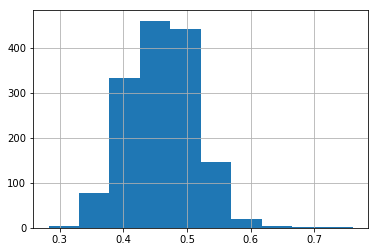

In [138]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [139]:
# ,encoding = "ISO-8859-1"
if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')

In [140]:
dtrain.target[:50]

810     0.0
7110    0.0
3967    0.0
3800    0.0
627     0.0
230     0.0
3195    0.0
361     0.0
5882    0.0
6011    0.0
4215    0.0
3192    0.0
591     0.0
5788    0.0
1886    0.0
5492    0.0
7373    0.0
1107    0.0
824     0.0
2086    0.0
6524    0.0
2767    0.0
5654    0.0
648     0.0
1400    0.0
5226    0.0
4942    0.0
2969    0.0
3590    0.0
3861    0.0
2428    0.0
1347    0.0
2021    0.0
7254    0.0
3997    0.0
5377    0.0
4383    0.0
5244    0.0
1659    0.0
208     0.0
1081    0.0
3524    0.0
4829    0.0
5968    0.0
7097    0.0
1699    0.0
5313    0.0
239     0.0
680     0.0
4965    0.0
Name: target, dtype: float64

In [141]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


337.0
percentage correct validate
0.773521505376


dict_keys(['val_loss', 'val_acc', 'val_weighted_acc', 'loss', 'acc', 'weighted_acc'])


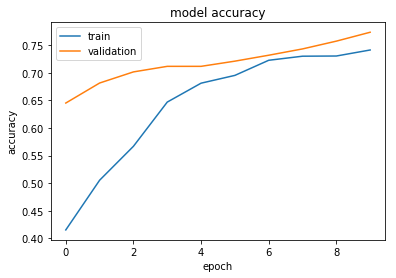

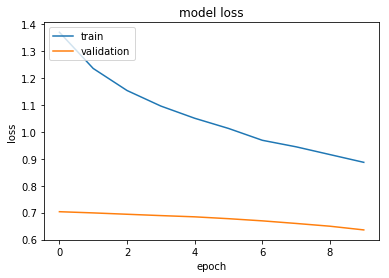

In [142]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

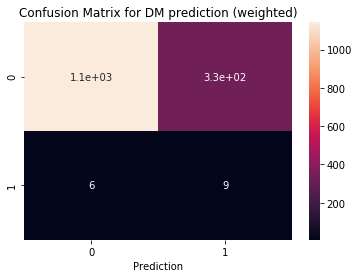

In [143]:
from sklearn import metrics

cfmap=metrics.confusion_matrix(y_true=dvalid['target'],  # True labels
                         y_pred=dvalid["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for DM prediction (weighted)")
plt.show()

In [144]:
model.metrics_names

['loss', 'acc', 'weighted_acc']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.